In [98]:
import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import skimage 

from matplotlib.pyplot import imread

#пути к файлам 

train_img_dir = '/Users/79266/Desktop/диплом/Модель Ship Detection/train_v2/'
test_img_dir = '/Users/79266/Desktop/диплом/Модель Ship Detection/test_v2/'
train_seg_csv = '/Users/79266/Desktop/диплом/Модель Ship Detection/train_ship_segmentations_v2.csv'
traincsv = pd.read_csv('/Users/79266/Desktop/диплом/Модель Ship Detection/train_ship_segmentations_v2.csv')

In [99]:
# Встроенные функции 

def rle_pixels(rle):
    '''
    Количество пикселей в объекте с помощью алгоритма RLE 
    (повторяющиеся группы элементов заменяются на пару(количество повторов, повторяющийся элемент))
    '''
    if rle.size > 0:
        return np.sum(rle[:,1])
    return 0


def rle_dims(rle):
    """ 
    Размер изображения с помощью алгоритма RLE (сжатие без потерь)
    """
    if rle.size > 0:
        return (np.max(rle[:,1]), len(rle))
    return (0,0)


def encodedpixels2rle(encodedpixels):
    if isinstance(encodedpixels, str):
        return np.array(list(zip(*[iter(int(x) for x in encodedpixels.split())]*2)))
    return np.array([])


def object_dims(encodedpixels):
    """ Размер изображения, закодированные с помощью 'encodedpixels' """
    return rle_dims(encodedpixels2rle(encodedpixels))


def object_pixels(encodedpixels):
    """ Номера пикселей, закодированных с помощью 'encodedpixels' """
    return rle_pixels(encodedpixels2rle(encodedpixels))


def rle2mask(rle, shape=(768, 768)):
    """
    RLE: Двумерный массив [start, run-length]
    shape: (rows, cols) Форма изображения
    """
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    run_ranges = [(start - 1, start + length - 1) for (start, length) in rle]

    for a, b in run_ranges:
        mask[a:b] = 1

    return mask.reshape(shape).T


def mask2rle(mask):
    mask = mask.T.ravel()
    
    start_mask = np.concatenate((mask[0:1] > 0, mask[1:] > mask[0:-1]))
    end_mask = np.concatenate((mask[0:-1] > mask[1:], mask[-1:] > 0))

    run_starts = np.where(start_mask.T.ravel())[0] # 0-based!
    run_lengths = np.where(end_mask.T.ravel())[0] - run_starts + 1

    return np.array(list(zip(run_starts + 1, run_lengths)))


def read_train_image(imgid):
    return(imread(train_img_dir + imgid ))


def read_test_image(imgid):
    return(imread(test_img_dir + imgid))


def get_train_masks(imgid):
    return [rle2mask(encodedpixels2rle(encodedpixels))
            for encodedpixels in 
                traincsv[traincsv.ImageId == imgid]['EncodedPixels']]


def get_train_combined_masks(imgid):
    return(rle2mask(encodedpixels2rle(' '.join(
        traincsv[traincsv.ImageId == imgid]['EncodedPixels'].fillna('').astype(str)))))


def get_train_objcount(imgid):
    return traincsv[traincsv.ImageId == imgid]['EncodedPixels'].count()

In [90]:
# Метрики
def IoU(mask1, mask2):
    Inter = np.sum((mask1 >= 0.5) & (mask2 >= 0.5))
    Union = np.sum((mask1 >= 0.5) | (mask2 >= 0.5))
    return Inter / (1e-8 + Union)

def fscore(tp, fn, fp, beta=2.):
    if tp + fn + fp < 1:
        return 1.
    num = (1 + beta ** 2) * tp
    return num / (num + (beta ** 2) * fn + fp)

def confusion_counts(predict_mask_seq, truth_mask_seq, iou_thresh=0.5):
    predict_masks = [m for m in predict_mask_seq if np.any(m >= 0.5)]
    truth_masks = [m for m in truth_mask_seq if np.any(m >= 0.5)]
    
    if len(truth_masks) == 0:
        tp, fn, fp = 0.0, 0.0, float(len(predict_masks))
        return tp, fn, fp

    pred_hits = np.zeros(len(predict_masks), dtype=np.bool) # 0 miss, 1 hit
    truth_hits = np.zeros(len(truth_masks), dtype=np.bool)  # 0 miss, 1 hit

    for p, pred_mask in enumerate(predict_masks):
        for t, truth_mask in enumerate(truth_masks):
            if IoU(pred_mask, truth_mask) > iou_thresh:
                truth_hits[t] = True
                pred_hits[p] = True

    tp = np.sum(pred_hits)
    fn = len(truth_masks) - np.sum(truth_hits)
    fp = len(predict_masks) - tp

    return tp, fn, fp

def mean_fscore(predict_mask_seq, truth_mask_seq,
              iou_thresholds=[0.5, 0.55, 0.6, 0.65, 0.7,
                              0.75, 0.8, 0.85, 0.9, 0.95], beta=2.):
    """ 
    Вычисляет среднюю FScore для предсказаний на изображении
    predict_mask_seq: список масок предсказываемых объектов на изображении
    """
    return np.mean(
        [fscore(tp, fn, fp, beta) for (tp, fn, fp) in 
            [confusion_counts(predict_mask_seq, truth_mask_seq, iou_thresh)
                for iou_thresh in iou_thresholds]])

In [103]:
#print("Общая сводка на тестовую выборку: " , traincsv.shape[0])

id_images = traincsv.ImageId.unique()
'''
    Функция Pandas dataframe.isna() используется для обнаружения пропущенных значений
'''
id_images_noships = traincsv[traincsv.EncodedPixels.isna()].ImageId.unique()
id_images_ships = traincsv[traincsv.EncodedPixels.notna()].ImageId.unique()

n_images = id_images.shape[0]
n_images_noships = id_images_noships.shape[0]
n_images_ships = id_images_ships.shape[0]

print("Количество изображений: ", n_images)
print("Изображения без кораблей: ", n_images_noships)
print("Изображения с кораблями: ", n_images_ships)

Количество изображений:  192556
Изображения без кораблей:  150000
Изображения с кораблями:  42556


In [76]:
id_images_noships

array(['0000000A1.jpg', '00003e153.jpg', '0001124c7.jpg', ...,
       'ffff6e525.jpg', 'ffffc50b4.jpg', 'ffffe97f3.jpg'], dtype=object)

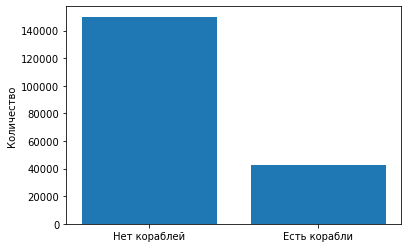

In [45]:
plt.bar(['Нет кораблей', 'Есть корабли'], [n_images_noships, n_images_ships]);
plt.ylabel('Количество');

In [46]:
id_images_obj = traincsv.dropna().groupby('ImageId').count()

id_images_obj.rename({'EncodedPixels': 'ObjCount'}, axis='columns', inplace=True)

objects = id_images_obj.ObjCount.sum()

print("Стастика по изображениям с кораблями")
print("Всего объектов на фотографиях: ", objects)

id_images_obj.describe()

Стастика по изображениям с кораблями
Всего объектов на фотографиях:  81723


,ObjCount
count,42556.000000
mean,1.920364
std,1.906073
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,15.000000


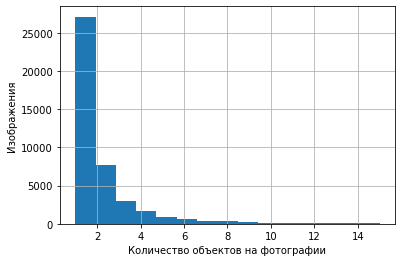

In [47]:
id_images_obj.ObjCount.hist(bins=15)
plt.xlabel('Количество объектов на фотографии');
plt.ylabel('Изображения');

count    81723.000000
mean      1567.402849
std       2842.081203
min          2.000000
25%        111.000000
50%        408.000000
75%       1550.000000
max      25904.000000
Name: EncodedPixels, dtype: float64

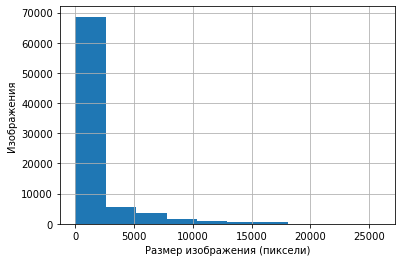

In [48]:
obj_pixels = traincsv.dropna().EncodedPixels.map(lambda x: object_pixels(x))

obj_pixels.hist()
plt.xlabel('Размер изображения (пиксели)');
plt.ylabel('Изображения');

obj_pixels.describe()

count    81723.000000
mean        57.077445
std         58.253226
min          2.000000
25%         16.000000
50%         35.000000
75%         76.000000
max        444.000000
Name: EncodedPixels, dtype: float64

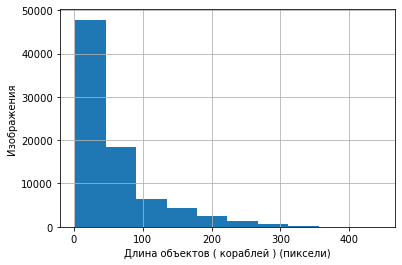

In [18]:
obj_maxdim = traincsv.dropna().EncodedPixels.map(lambda x: max(object_dims(x)))

obj_maxdim.hist()

plt.xlabel('Длина объектов ( кораблей ) (пиксели)');
plt.ylabel('Изображения');

obj_maxdim.describe()

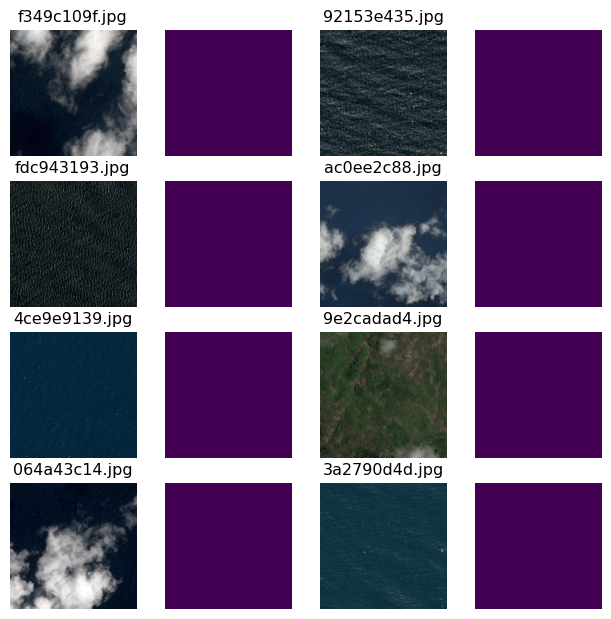

In [91]:
fig, ax = plt.subplots(4, 4, figsize=(8, 8), dpi=96)

ax = ax.reshape(-1)

for a in ax: 
    a.axis('off')

imgids = np.random.choice(id_images_noships, 8, replace=False)

for i, imgid in enumerate(imgids):
    msk = get_train_combined_masks(imgid)
    ax[2*i].imshow(read_train_image(imgid))
    ax[2*i].set_title(imgid)
    ax[2*i+1].imshow(msk)

1.0

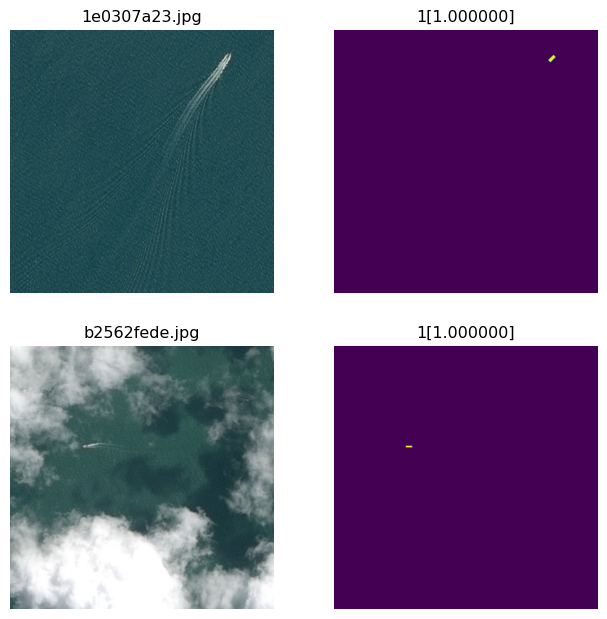

In [109]:
k=2
#subplots (столбец, строка)
fig, ax = plt.subplots(k, k, figsize=(8, 8), dpi=96)

ax = ax.reshape(-1)

for a in ax: 
    a.axis('off')

imgids = np.random.choice(id_images_ships, round(k*k/2), replace=False)

for i, imgid in enumerate(imgids):
    msk = get_train_combined_masks(imgid)
    msk
    avg_fscore = mean_fscore([msk], get_train_masks(imgid))
    ax[2*i].imshow(read_train_image(imgid))
    ax[2*i].set_title(imgid)
    ax[2*i+1].imshow(msk)
    ax[2*i+1].set_title("%s[%f]" % (get_train_objcount(imgid), avg_fscore))
avg_fscore